In [1]:
from sklearn.dummy import DummyClassifier
import pandas as pd
import numpy as np
import xgboost as xgb
# from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest, shapiro, probplot
# import datawig

/Users/wolfrieder/miniconda3/envs/code/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
train_data = pd.read_parquet("../data/processed/chrome/08_12_2022/train_set_01_processed.parquet.gzip")
test_data = pd.read_parquet("../data/processed/chrome/08_12_2022/test_set_01_processed.parquet.gzip")

In [3]:
train_data

,hostname,pathname,filetype,filename,pragma,content-type,last-modified,accept-ranges,etag,p3p,...,x-b3-spanid,x-hubspot-correlation-id,x-hs-target-asset,x-hostname,x-cdn-pop,x-cdn-pop-ip,tracker,header_count,comb_col_non_tracker,comb_col_tracker
0,tpc.googlesyndication.com,/pagead/js/r20220810/r20110914/client/one_clic...,js,one_click_handler_one_afma_fy2021.js,NaN,text/javascript; charset=utf-8,NaN,NaN,15601544113783900868,"policyref=""https://www.googleadservices.com/pa...",...,NaN,NaN,NaN,NaN,NaN,NaN,1,17,0,0
1,res.cdn.office.net,/officehub/bundles/staying-aware.b8b088b355c55...,js,staying-aware.b8b088b355c55b4ea7d6.chunk.v6.js,NaN,application/javascript,"mon, 08 aug 2022 21:56:59 gmt",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,14,2,0
2,www.google.com,/ads/ga-audiences,/ads/ga-audiences,ga-audiences,no-cache,image/gif,NaN,NaN,NaN,"policyref=""https://www.googleadservices.com/pa...",...,NaN,NaN,NaN,NaN,NaN,NaN,1,13,0,0
3,ipv4-c113-lhr004-ix.1.oca.nflxvideo.net,/speedtest/range/0-0,/speedtest/range/0-0,0-0,no-cache,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,10,1,0
4,shimo.im,/,/,,NaN,text/html; charset=utf-8,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271999,www.criteo.com,/wp-content/uploads/2021/01/ss-logo-Lamps-Plus...,png,ss-logo-Lamps-Plus.png,NaN,image/png,"fri, 12 nov 2021 05:09:38 gmt",bytes,"""618df712-2509""",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,22,5,0
272000,ads.adfox.ru,/260122/event,/260122/event,event,no-cache,NaN,"fri, 12 aug 2022 09:22:13 gmt",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1,8,0,0
272001,synostatic.synology.com,/font/inter/inter-w400-6.woff2,woff2,inter-w400-6.woff2,NaN,binary/octet-stream,"mon, 20 dec 2021 02:24:19 gmt",bytes,"""4abfa4888190370d347034f9fa43c804""",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,16,0,0
272002,tenor.com,/opensearch.xml,xml,opensearch.xml,NaN,application/xml,"thu, 26 apr 2018 18:25:27 gmt",bytes,"w/""29a-1630333f5d8""",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,22,2,0


In [3]:
train_data = train_data.iloc[:, 4:]
test_data = test_data.iloc[:, 4:]

In [4]:
list_of_integer_cols = list(train_data.iloc[:, :-4].select_dtypes('Int64').columns.values.tolist())

In [129]:
a = train_data[train_data['content-length'].notnull()]['content-length'].to_numpy().astype(np.int64)

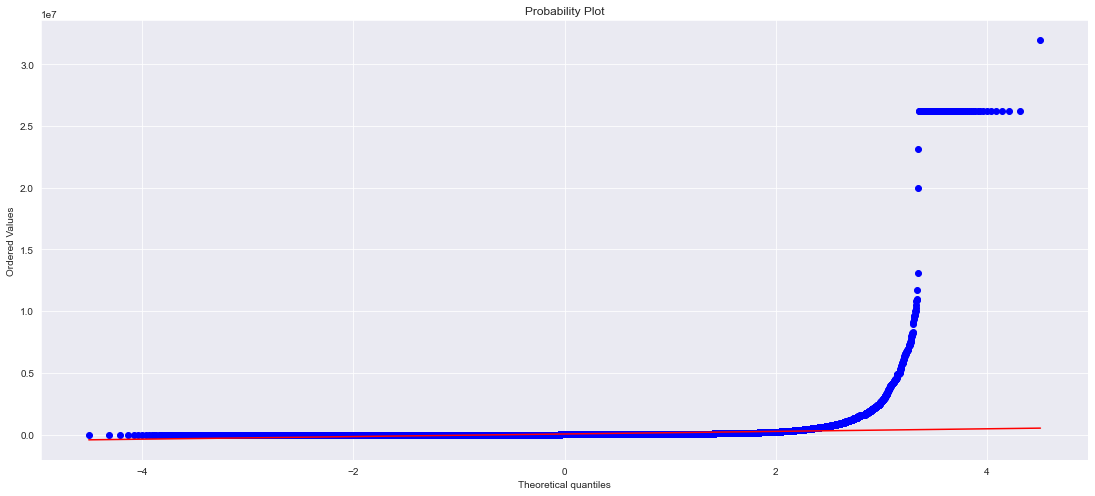

In [130]:
fig2 = plt.figure(figsize=(30, 7))
ax3 = fig2.add_subplot(1, 2, 1)
probplot(a, dist='norm', plot=ax3)
fig2.tight_layout()
plt.show()

In [135]:
def check_distribution(dataset, feature, distribution):
    values = dataset[dataset[feature].notnull()][feature]
    sample_size = {5001: 1067, 5000: 880, 2500: 748, 1000: 516, 500: 341, 200: 169}
    sample_values = [v for v in sample_size.keys() if len(values) > v]
    if len(sample_values) == 0:
        n = int(len(values) * 0.1)
    else:
        n = sample_size[sample_values[0]]
    feature_values = values.sample(n=n, random_state=10).to_numpy().astype(np.int64)
    stat, p_value = shapiro(feature_values) # kstest(feature_values, 'norm')
    return stat, p_value

In [136]:
for col in list_of_integer_cols:
    print(check_distribution(train_data, col, 'norm'))

(0.29529869556427, 0.0)
(0.6642665863037109, 6.451095634664221e-36)
(0.5888121128082275, 1.208368506451395e-27)
(0.834446907043457, 1.9135712981441943e-18)
(0.15520459413528442, 0.0)
(0.26958900690078735, 1.7706358907953323e-34)
(0.2968154549598694, 4.278720906236679e-25)
(0.8256344795227051, 6.223809987347673e-13)
(0.7801094055175781, 4.21312853166199e-21)
(0.06737428903579712, 1.2599930966365826e-37)
(0.09728425741195679, 3.3768185470753605e-37)
(0.695381760597229, 2.8090679716663946e-17)
(0.49541109800338745, 8.313267644966734e-22)
(0.7211127281188965, 0.0009099743328988552)
(0.33079594373703003, 1.3732526136828108e-24)


In [155]:
def compute_outlier_boundaries(dataset, feature, distribution):
    if distribution == 'skewed':
        IQR = dataset[feature].quantile(0.75) - dataset[feature].quantile(0.25)
        lower_boundary = dataset[feature].quantile(0.25) - (IQR * 1.5)
        upper_boundary = dataset[feature].quantile(0.75) + (IQR * 1.5)
        # print('Fare outliers are values < {lowerboundary} or > {upperboundary}'.format(lowerboundary=lower_boundary, upperboundary=upper_boundary))
        return int(lower_boundary), int(upper_boundary)

In [142]:
compute_outlier_boundaries(train_data, 'content-length', 'skewed')

Fare outliers are values < -32819.5 or > 55592.5


In [163]:
def cap_outlier_values(dataset, feature, lower_bound, upper_bound):
    dataset.loc[dataset[feature] > upper_bound, feature] = upper_bound
    dataset.loc[dataset[feature] < lower_bound, feature] = lower_bound

    print(dataset[feature].describe())

    # test_dataset.loc[test_dataset[feature] > upper_bound, feature] = upper_bound
    # test_dataset.loc[test_dataset[feature] > lower_bound, feature] = lower_bound

In [146]:
data_copy = train_data.copy(deep=True)

In [165]:
low, up = compute_outlier_boundaries(data_copy, 'content-length', 'skewed')
print(low, up)
cap_outlier_values(train_data, 'content-length', low, up)

-32819 55592
count    211540.0
mean     -32819.0
std           0.0
min      -32819.0
25%      -32819.0
50%      -32819.0
75%      -32819.0
max      -32819.0
Name: content-length, dtype: float64


In [180]:
np.percentile(data_copy[data_copy['content-length'].notnull()]['content-length'], 95)

np.where(data_copy[data_copy['content-length'].notnull()]['content-length'] > 122660, 122660,
         data_copy[data_copy['content-length'].notnull()]['content-length'])

array([13475, 4768, 42, ..., 57064, 666, 70473], dtype=object)

In [12]:
# https://sparkbyexamples.com/pandas/pandas-change-position-of-a-column/
def label_as_last_column(dataset):
    temp_cols = dataset.columns.tolist()
    index_col = dataset.columns.get_loc("tracker")
    new_col_order = temp_cols[0:index_col] + temp_cols[index_col+1:] + temp_cols[index_col:index_col+1]
    return new_col_order

In [13]:
reordered_cols = label_as_last_column(train_data)
train_data = train_data[reordered_cols]
test_data = test_data[reordered_cols]

In [8]:
X_train, y_train = train_data.iloc[:, :-1], train_data[["tracker"]]
X_test, y_test = test_data.iloc[:, :-1], test_data[["tracker"]]

In [4]:
def variance_per_column_2(column):
    tracker_ratio = train_data[train_data[column].notnull()].tracker.value_counts()
    try:
        trackers = tracker_ratio[1]
    except KeyError:
        trackers = 0
    try:
        non_trackers = tracker_ratio[0]
    except KeyError:
        non_trackers = 0
    return [column, trackers, non_trackers]

In [5]:
number_of_elements_reduced = np.array(
    [variance_per_column_2(column) for column in train_data.iloc[:, :-4].columns]
)
summary_table = pd.DataFrame(
    number_of_elements_reduced, columns=["header_name", "trackers", "non_trackers"]
)

summary_table["trackers"] = summary_table["trackers"].astype("Int32")
summary_table["non_trackers"] = summary_table["non_trackers"].astype("float32")

In [6]:
number_of_trackers = len(train_data[train_data['tracker'] == 1])
number_of_non_trackers = len(train_data[train_data['tracker'] == 0])
summary_table['ratio_tracker'] = summary_table['trackers'] / number_of_trackers
summary_table['ratio_non_tracker'] = summary_table['non_trackers'] / number_of_non_trackers
summary_table['tracker_na_ratio'] = train_data[train_data['tracker'] == 1].iloc[:, :-4].isnull().mean().values
summary_table['non_tracker_na_ratio'] = train_data[train_data['tracker'] == 0].iloc[:, :-4].isnull().mean().values

In [7]:
summary_table

,header_name,trackers,non_trackers,ratio_tracker,ratio_non_tracker,tracker_na_ratio,non_tracker_na_ratio
0,pragma,25805,8853.0,0.333747,0.045473,0.666253,0.954527
1,content-type,70183,191835.0,0.907707,0.985361,0.092293,0.014639
2,last-modified,27829,154469.0,0.359924,0.793430,0.640076,0.206570
3,accept-ranges,15119,116366.0,0.195541,0.597714,0.804459,0.402286
4,etag,18194,129781.0,0.235311,0.666620,0.764689,0.333380
...,...,...,...,...,...,...,...
145,x-hubspot-correlation-id,127,267.0,0.001643,0.001371,0.998357,0.998629
146,x-hs-target-asset,63,76.0,0.000815,0.000390,0.999185,0.999610
147,x-hostname,116,61.0,0.0015,0.000313,0.998500,0.999687
148,x-cdn-pop,17,122.0,0.00022,0.000627,0.999780,0.999373


In [8]:
na_ratio_greater_than_85 = summary_table[summary_table['tracker_na_ratio'] >= 0.85].header_name.values.tolist()

In [9]:
# list_of_dfs = []
for elem in na_ratio_greater_than_85:
    train_data[f'{elem}_binary'] = np.where(train_data[elem].isnull(), 0, 1)
    test_data[f'{elem}_binary'] = np.where(test_data[elem].isnull(), 0, 1)
    # list_of_dfs.append(pd.DataFrame(np.where(X_train[elem].isnull(), 0, 1), columns=[f'{elem}_binary']))

# pd.concat(list_of_dfs)

<ipython-input-9-1f75fc38838f>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data[f'{elem}_binary'] = np.where(train_data[elem].isnull(), 0, 1)
<ipython-input-9-1f75fc38838f>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_data[f'{elem}_binary'] = np.where(test_data[elem].isnull(), 0, 1)
<ipython-input-9-1f75fc38838f>:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.con

In [15]:
train_data.drop(na_ratio_greater_than_85, axis=1, inplace=True)
test_data.drop(na_ratio_greater_than_85, axis=1, inplace=True)

In [16]:
train_data.drop(['last-modified', 'date'], axis=1, inplace=True)
test_data.drop(['last-modified', 'date'], axis=1, inplace=True)

if time check sun, 17 may 1998 03:00:00 gmt for last-modified -> trackers

In [15]:
train_data.dtypes

pragma                             category
content-type                       category
accept-ranges                      category
etag                               category
p3p                                category
                                     ...   
x-hubspot-correlation-id_binary       int64
x-hs-target-asset_binary              int64
x-hostname_binary                     int64
x-cdn-pop_binary                      int64
x-cdn-pop-ip_binary                   int64
Length: 152, dtype: object

In [66]:
int_col_list = list(train_data.iloc[:, :].select_dtypes('Int64').columns.values.tolist())

In [25]:
df_train, df_test = datawig.utils.random_split(train_data)

In [26]:
input_cols = train_data.columns.values.tolist()

In [27]:
input_cols = train_data.columns.values.tolist()

In [104]:
df_train['etag'] = df_train['etag'].replace({np.nan : pd.NA})

In [116]:
train_data[[row for row in input_cols if train_data[row].dtype != 'object']].dtypes

header_count                int64
comb_col_non_tracker        int64
comb_col_tracker            int64
x-robots-tag_binary         int64
connection_binary           int64
                            ...  
x-hs-target-asset_binary    int64
x-hostname_binary           int64
x-cdn-pop_binary            int64
x-cdn-pop-ip_binary         int64
tracker                     int32
Length: 132, dtype: object

In [32]:
df_train.dropna(subset=['content-length'], inplace=True)

In [37]:
[row for row in input_cols if train_data[row].dtype != 'category']

['tracker',
 'header_count',
 'comb_col_non_tracker',
 'comb_col_tracker',
 'x-robots-tag_binary',
 'connection_binary',
 'x-amz-server-side-encryption_binary',
 'x-amz-version-id_binary',
 'x-cache_binary',
 'via_binary',
 'x-amz-cf-pop_binary',
 'x-amz-cf-id_binary',
 'x-guploader-uploadid_binary',
 'x-goog-generation_binary',
 'x-goog-hash_binary',
 'x-goog-storage-class_binary',
 'cf-cache-status_binary',
 'expect-ct_binary',
 'report-to_binary',
 'nel_binary',
 'cf-ray_binary',
 'set-cookie_binary',
 'content-security-policy-report-only_binary',
 'access-control-expose-headers_binary',
 'access-control-allow-headers_binary',
 'access-control-max-age_binary',
 'x-powered-by_binary',
 'cross-origin-opener-policy-report-only_binary',
 'content-security-policy_binary',
 'cross-origin-opener-policy_binary',
 'x-frame-options_binary',
 'x-fb-debug_binary',
 'priority_binary',
 'x-amz-id-2_binary',
 'x-amz-request-id_binary',
 'access-control-allow-methods_binary',
 'x-served-by_binary',

In [44]:
df_train[[row for row in train_data.columns.values.tolist() if train_data[row].dtype != 'category']]

,content-length,tracker,header_count,comb_col_non_tracker,comb_col_tracker,x-robots-tag_binary,connection_binary,x-amz-server-side-encryption_binary,x-amz-version-id_binary,x-cache_binary,...,x-amz-meta-codebuild-buildarn_binary,x-amz-meta-codebuild-content-md5_binary,x-llid_binary,x-b3-sampled_binary,x-b3-spanid_binary,x-hubspot-correlation-id_binary,x-hs-target-asset_binary,x-hostname_binary,x-cdn-pop_binary,x-cdn-pop-ip_binary
248002,740,0,9,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60016,8072,0,15,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4675,37,1,7,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9159,2089,0,13,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
71907,21,0,11,2,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55305,4,1,14,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
234622,354,0,15,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
240929,15161,1,16,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
67023,8216,0,23,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [87]:
# imputer = datawig.Imputer(
#     data_featurizers=[datawig.NumericalFeaturizer(row) for row in input_cols if train_data[row].dtype != 'object'],
#     data_encoders=[datawig.NumericalEncoder(row) for row in input_cols if train_data[row].dtype != 'object'],
#     label_encoders= [datawig.column_encoders.NumericalEncoder('content-length')],
#     output_path = 'artifacts/imputer_model'
# )

imputer_num = datawig.SimpleImputer(
            input_columns=['tracker'],
            output_column='server',  # Column to be imputed
            output_path='artifacts/imputer_model_num'  # Store model data and metrics
            )

In [ ]:
imputer_num.fit(train_df=df_train[['tracker', 'server']])

In [ ]:
predictions_num = imputer_num.predict(df_test[['server', 'tracker']])

In [100]:
if df_test.columns.contains('server'):
    print("yes")

AttributeError: 'Index' object has no attribute 'contains'

In [83]:
df_test[[row for row in train_data.columns.values.tolist() if train_data[row]
                                      .dtype != 'category' or row == 'server']]

,content-length,server,tracker,header_count,comb_col_non_tracker,comb_col_tracker,x-robots-tag_binary,connection_binary,x-amz-server-side-encryption_binary,x-amz-version-id_binary,...,x-amz-meta-codebuild-buildarn_binary,x-amz-meta-codebuild-content-md5_binary,x-llid_binary,x-b3-sampled_binary,x-b3-spanid_binary,x-hubspot-correlation-id_binary,x-hs-target-asset_binary,x-hostname_binary,x-cdn-pop_binary,x-cdn-pop-ip_binary
7097,77143.0,NaN,0,12,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
259082,3661.0,NaN,0,16,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
237076,2500.0,akamai resource optimizer,0,16,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57567,1054.0,nginx,0,20,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13310,NaN,NaN,0,10,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140296,NaN,nginx,1,14,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
108445,4833.0,none,0,9,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9372,81524.0,nginx,0,20,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
105595,624.0,NaN,0,7,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [70]:
df_test['content-length'] = df_test['content-length'].astype('float64')

In [78]:
df_test[[row for row in train_data.columns.values.tolist() if train_data[row].dtype != 'category']].dtypes

content-length                     float64
tracker                              int32
header_count                         int64
comb_col_non_tracker                 int64
comb_col_tracker                     int64
                                    ...   
x-hubspot-correlation-id_binary      int64
x-hs-target-asset_binary             int64
x-hostname_binary                    int64
x-cdn-pop_binary                     int64
x-cdn-pop-ip_binary                  int64
Length: 133, dtype: object

In [37]:
list_of_categorical_cols = list(X_train.iloc[:, :-3].select_dtypes('category').columns.values.tolist())
list_of_integer_cols = list(X_train.iloc[:, :-3].select_dtypes('Int64').columns.values.tolist())

In [11]:
impute_col_list_t = summary_table[summary_table['ratio_tracker'] > 0.4].header_name.values.tolist()
impute_col_list_nt = summary_table[summary_table['ratio_non_tracker'] > 0.4].header_name.values.tolist()

In [13]:
impute_col_list_t

['content-type',
 'vary',
 'content-encoding',
 'cache-control',
 'expires',
 'date',
 'content-length',
 'server',
 'alt-svc',
 'access-control-allow-origin',
 'cross-origin-resource-policy']

In [10]:
summary_table

,header_name,trackers,non_trackers,ratio_tracker,ratio_non_tracker,tracker_na_ratio,non_tracker_na_ratio
0,pragma,25805,8853.0,0.333747,0.045473,0.666253,0.954527
1,content-type,70183,191835.0,0.907707,0.985361,0.092293,0.014639
2,last-modified,27829,154469.0,0.359924,0.793430,0.640076,0.206570
3,accept-ranges,15119,116366.0,0.195541,0.597714,0.804459,0.402286
4,etag,18194,129781.0,0.235311,0.666620,0.764689,0.333380
...,...,...,...,...,...,...,...
145,x-hubspot-correlation-id,127,267.0,0.001643,0.001371,0.998357,0.998629
146,x-hs-target-asset,63,76.0,0.000815,0.000390,0.999185,0.999610
147,x-hostname,116,61.0,0.0015,0.000313,0.998500,0.999687
148,x-cdn-pop,17,122.0,0.00022,0.000627,0.999780,0.999373


### High cardinality features

In [44]:
# should be in data processing
train_data.replace(" ", np.nan, inplace=True)
test_data.replace(" ", np.nan, inplace=True)

train_data.replace("", np.nan, inplace=True)
test_data.replace("", np.nan, inplace=True)

In [35]:
# filter high cardinality features
train_data.loc[:, train_data.nunique() > 1000]

,etag,cache-control,expires,content-length,server,age,access-control-allow-origin
0,15601544113783900868,"public, max-age=1209600","fri, 26 aug 2022 11:22:22 gmt",13475,cafe,5806,NaN
1,NaN,max-age=630720000,NaN,4768,NaN,NaN,*
2,NaN,"no-cache, no-store, must-revalidate","fri, 01 jan 1990 00:00:00 gmt",42,cafe,NaN,NaN
3,NaN,no-store,NaN,0,nginx,NaN,*
4,NaN,"private, max-age=0","sun, 01 feb 1970 00:00:00 gmt",<NA>,NaN,NaN,NaN
...,...,...,...,...,...,...,...
271999,"""618df712-2509""",max-age=31622400,"thu, 03 aug 2023 14:44:48 gmt",9481,nginx,845572,NaN
272000,NaN,"no-store, no-cache, must-revalidate, max-age=0","mon, 04 dec 1999 21:29:02 gmt",<NA>,NaN,NaN,*
272001,"""4abfa4888190370d347034f9fa43c804""",NaN,NaN,57064,amazons3,709890,https://www.synology.com
272002,"w/""29a-1630333f5d8""","public, max-age=86400",NaN,666,NaN,28523,NaN


In [36]:
train_data['etag'] = train_data['etag'].astype('object')

In [38]:
train_data['etag'].replace(to_replace=r'^w\/', value='', regex=True, inplace=True)

In [39]:
train_data['etag'] = train_data['etag'].astype('category')

In [46]:
train_data['etag'].value_counts()

"1660137096112928"                               386
"ad4b0f606e0f8465bc4c4c170b37e1a3:1463757360"    370
12862140795212465669                             324
0x8da7b64a03a8ae5                                312
1484984001845508991                              241
                                                ... 
"5efd4994-2b"                                      1
"5efc256e:15a"                                     1
"5efb9ec6d8c88d1176a042005edc2108"                 1
"5efb3bfa-b66e1"                                   1
zaknedhzmad9temmhrdjeq==                           1
Name: etag, Length: 113852, dtype: int64

In [50]:
%%time
train_data['etag'].apply(len)

CPU times: user 13 µs, sys: 1 µs, total: 14 µs
Wall time: 15.7 µs


In [57]:
from collections import Counter


# https://towardsdatascience.com/dealing-with-features-that-have-high-cardinality-1c9212d7ff1b
def cumulatively_categorise(column,threshold=0.75,return_categories_list=True):
  #Find the threshold value using the percentage and number of instances in the column
  threshold_value=int(threshold*len(column))
  #Initialise an empty list for our new minimised categories
  categories_list=[]
  #Initialise a variable to calculate the sum of frequencies
  s=0
  #Create a counter dictionary of the form unique_value: frequency
  counts=Counter(column)

  #Loop through the category name and its corresponding frequency after sorting the categories by descending order of frequency
  for i,j in counts.most_common():
    #Add the frequency to the global sum
    s+=dict(counts)[i]
    #Append the category name to the list
    categories_list.append(i)
    #Check if the global sum has reached the threshold value, if so break the loop
    if s>=threshold_value:
      break
  #Append the category Other to the list
  categories_list.append('Other')

  #Replace all instances not in our new categories by Other
  new_column=column.apply(lambda x: x if x in categories_list else 'Other')

  #Return transformed column and unique values if return_categories=True
  if return_categories_list:
    return new_column,categories_list
  #Return only the transformed column if return_categories=False
  else:
    return new_column


#Call the function with a default threshold of 75%
transformed_column,new_category_list=cumulatively_categorise(train_data['access-control-allow-origin'],return_categories_list=True)

In [60]:
transformed_column.value_counts()

*        102011
Other     29287
Name: access-control-allow-origin, dtype: int64

In [66]:
train_data['age'] = train_data['age'].astype('object')

In [96]:
[row for row in train_data.loc[train_data.age.notnull(), 'age'].values.tolist() if row == '0        2']

['0        2']

In [98]:
train_data.age.replace(to_replace=r'^0        2', value=0, regex=True, inplace=True)

In [111]:
train_data.loc[train_data.age.notnull(), 'age'].astype('int64')

0               0
5               0
7         3877441
9               2
11         298179
           ...   
271996     216994
271997          0
271999     845572
272001          0
272002      28523
Name: age, Length: 115863, dtype: int64

In [108]:
train_data[train_data.age == 'null']

,pragma,content-type,accept-ranges,etag,p3p,x-xss-protection,x-content-type-options,strict-transport-security,vary,content-encoding,...,x-amz-meta-codebuild-buildarn_binary,x-amz-meta-codebuild-content-md5_binary,x-llid_binary,x-b3-sampled_binary,x-b3-spanid_binary,x-hubspot-correlation-id_binary,x-hs-target-asset_binary,x-hostname_binary,x-cdn-pop_binary,x-cdn-pop-ip_binary
75032,NaN,application/json; charset=utf-8,NaN,NaN,NaN,NaN,NaN,NaN,accept-encoding,NaN,...,0,0,0,0,0,0,0,0,0,0
164954,NaN,text/html;charset=utf-8,NaN,NaN,NaN,NaN,NaN,NaN,"host, accept-encoding",gzip,...,0,0,0,0,0,0,0,0,0,0
217966,NaN,text/html;charset=utf-8,NaN,NaN,NaN,NaN,NaN,NaN,accept-encoding,gzip,...,0,0,0,0,0,0,0,0,0,0
241165,NaN,text/html;charset=utf-8,NaN,NaN,NaN,NaN,NaN,NaN,accept-encoding,gzip,...,0,0,0,0,0,0,0,0,0,0


In [109]:
train_data.age.replace("null", np.nan, inplace=True)

In [113]:
train_data.age.astype('float64')

0              0.0
1              NaN
2              NaN
3              NaN
4              NaN
            ...   
271999    845572.0
272000         NaN
272001         0.0
272002     28523.0
272003         NaN
Name: age, Length: 272004, dtype: float64

In [114]:
train_data.server.value_counts()

cloudflare                39976
nginx                     36629
amazons3                  21756
cafe                      11677
sffe                      10515
                          ...  
bcebos                        1
ecacc (dcb/7f20)              1
openresty/1.11.2.1            1
openresty+                    1
jetty(8.1.9.v20130131)        1
Name: server, Length: 1312, dtype: int64

In [130]:
train_data.server = train_data.server.astype('object')

In [138]:
# train_data.server.replace(to_replace=r'^nginx.*', value='nginx', regex=True, inplace=True)
# train_data.server.replace(to_replace=r'^apache.*', value='apache', regex=True, inplace=True)
# train_data.server.replace(to_replace=r'^ecacc.*', value='ecacc', regex=True, inplace=True)
# train_data.server.replace(to_replace=r'^ecs.*', value='ecs', regex=True, inplace=True)
# train_data.server.replace(to_replace=r'^oracle.*', value='oracle', regex=True, inplace=True)
# train_data.server.replace(to_replace=r'^mt3.*', value='mt3', regex=True, inplace=True)
# train_data.server.replace(to_replace=r'^microsoft.*', value='microsoft', regex=True, inplace=True)

train_data.server.replace(to_replace=r'^jetty.*', value='jetty', regex=True, inplace=True)
train_data.server.replace(to_replace=r'^ats.*', value='ats', regex=True, inplace=True)
train_data.server.replace(to_replace=r'^openresty.*', value='openresty', regex=True, inplace=True)

In [139]:
train_data.server.value_counts()

nginx                                                                        46640
cloudflare                                                                   39976
amazons3                                                                     21756
apache                                                                       12932
cafe                                                                         11677
                                                                             ...  
ycalb                                                                            1
clingest-secure i-05a627d2e9546ffbd                                              1
web_push_view/0.10.0 (web-push-view)                                             1
match/6913.98ef00e9c398630524ec3cc55780a8569dd8e00d (i-08860c73bcd65dae3)        1
opendns                                                                          1
Name: server, Length: 710, dtype: int64

In [146]:
transformed_column_server,new_category_list_server=cumulatively_categorise(train_data.server, threshold=0.9,
                                                              return_categories_list=True)

In [147]:
transformed_column_server.value_counts()

nginx                        46640
cloudflare                   39976
Other                        26837
amazons3                     21756
apache                       12932
cafe                         11677
sffe                         10515
golfe2                        5977
tengine                       5315
akamainetstorage              4290
server                        3731
openresty                     3562
google tag manager            3305
esf                           2684
akamai image manager          2658
microsoft                     2595
uploadserver                  2396
akamai resource optimizer     2393
envoy                         1771
proxygen-bolt                 1564
ecacc                         1398
cloudinary                    1389
istio-envoy                   1297
ats                           1143
ecs                           1037
kittenx                        989
contentful images api          752
gse                            723
cowboy              

In [150]:
train_data['content-length'].value_counts()

0         11886
43         6475
42         5072
35         2267
2          1750
          ...  
12215         1
11765         1
270979        1
110846        1
70473         1
Name: content-length, Length: 53006, dtype: Int64

In [154]:
train_data['content-length'].dtype

Int64Dtype()

In [126]:
imputed_values_dict = {0: [], 1: []}

In [127]:
def impute_value(element, classification):
    if element in list_of_integer_cols:
        value = int(train_data[train_data['tracker']==classification][element].median())
        imputed_values_dict[classification].append({element: value})
        train_data.loc[train_data['tracker'] == classification, element] = train_data.loc[train_data['tracker'] ==
                                                                                          classification, element]\
            .fillna(value)

    if element in list_of_categorical_cols:
        value = train_data[train_data['tracker']==classification][element].mode().iloc[0]
        imputed_values_dict[classification].append({element: value})
        train_data.loc[train_data['tracker'] == classification, element] = train_data.loc[train_data['tracker'] ==
                                                                                          classification, element]\
            .fillna(value)

In [182]:
for header in impute_col_list_t:
    impute_value(header, 0)

for header in impute_col_list_t:
    impute_value(header, 1)

for header in impute_col_list_nt:
    impute_value(header, 1)

for header in impute_col_list_nt:
    impute_value(header, 0)

In [183]:
for elem in imputed_values_dict[0]:
    (key, value), = elem.items()
    test_data.loc[train_data['tracker'] == 0, key] = test_data.loc[train_data['tracker'] == 0, key].fillna(value)
    # test_data[test_data['tracker'] == 0][key].fillna(value)

In [184]:
for elem in imputed_values_dict[1]:
    (key, value), = elem.items()
    test_data.loc[train_data['tracker'] == 1, key] = test_data.loc[train_data['tracker'] == 1, key].fillna(value)

Train dummy classifier

In [98]:
%%time
dummy_clf = DummyClassifier(strategy="uniform", random_state=10)
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_train, y_train)

CPU times: user 23.7 ms, sys: 1.14 ms, total: 24.8 ms
Wall time: 24.7 ms


0.4994050105206749

In [175]:
X_test

,hostname,pathname,filetype,filename,pragma,content-type,last-modified,accept-ranges,etag,p3p,...,x-b3-sampled,x-b3-spanid,x-hubspot-correlation-id,x-hs-target-asset,x-hostname,x-cdn-pop,x-cdn-pop-ip,header_count,comb_col_non_tracker,comb_col_tracker
0,static.pornpics.de,/style4/img/1px.png,png,1px.png,NaN,image/png,"thu, 26 sep 2019 10:11:41 gmt",bytes,"""5d8c8edd-44""",NaN,...,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,14,1,0
1,www.apple.com,/wss/fonts/SF-Pro-Display/v3/sf-pro-display_bo...,woff2,sf-pro-display_bold-italic.woff2,NaN,font/woff2,"thu, 16 jun 2022 22:54:46 gmt",NaN,NaN,NaN,...,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,14,0,0
2,www.comodo.com,/wp-content/themes/comodo-child/assets/js/jque...,js,jquery.validate.js,NaN,application/javascript,"thu, 21 jul 2022 02:07:42 gmt",bytes,"""62d8b4ee-957e""",NaN,...,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,13,0,0
3,wpastra.com,/wp-content/uploads/2021/12/wp-logo.png,png,wp-logo.png,NaN,image/webp,"thu, 02 dec 2021 07:36:15 gmt",bytes,"""61a8776f-18ea""",NaN,...,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,24,2,0
4,www.o2.pl,/MHgxNjAuYikGGjhZbg5vPUVCbEUnWn9nARk4AyIaI2VWT...,/MHgxNjAuYikGGjhZbg5vPUVCbEUnWn9nARk4AyIaI2VWT...,MHgxNjAuYikGGjhZbg5vPUVCbEUnWn9nARk4AyIaI2VWTn...,NaN,image/png,"thu, 14 nov 2019 13:45:36 gmt",bytes,"""3232f62028480cd85f19072341a56a4c""",NaN,...,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,14,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67996,api-2-0.spot.im,/v1.0.0/owa-gw/spot/sp_psR3LEKl/v2,0/owa-gw/spot/sp_psR3LEKl/v2,v2,NaN,application/json,NaN,NaN,NaN,NaN,...,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,16,0,0
67997,www.google-analytics.com,/plugins/ua/linkid.js,js,linkid.js,NaN,text/javascript,"tue, 22 oct 2019 18:15:00 gmt",bytes,NaN,NaN,...,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,17,0,0
67998,login.ibm.com,/v1/mgmt/idaas/user/status/,/v1/mgmt/idaas/user/status/,,NaN,application/json,NaN,NaN,NaN,"cp=""non cur otpi our nor uni""",...,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,21,5,0
67999,dev.to,/,/,,NaN,text/html; charset=utf-8,NaN,bytes,"w/""45a86e113f5f6aba3e2291d4c140d07c""",NaN,...,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,28,4,0


In [25]:
y_train.dtypes

tracker    int32
dtype: object

In [223]:
a = label_encoder.fit_transform(y_train['tracker'])

In [188]:
X_test = X_test.dropna(axis=1, how='any').iloc[:, 4:]
X_train_2 = X_train.dropna(axis=1, how='any').iloc[:, 4:]

In [213]:
model = xgb.XGBClassifier()

In [224]:
model.fit(X_train_2, a)

/Users/wolfrieder/miniconda3/envs/code/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


ValueError: DataFrame.dtypes for data must be int, float, bool or category.  When
categorical type is supplied, DMatrix parameter `enable_categorical` must
be set to `True`. Invalid columns:content-length

In [148]:
preprocessing.OneHotEncoder().fit_transform(X_train_2)

<253786x424659 sparse matrix of type '<class 'numpy.float64'>'
	with 4314362 stored elements in Compressed Sparse Row format>

In [28]:
label_encoder = preprocessing.LabelEncoder()

In [69]:
# X_test = X_test[X_train_2.columns.values.tolist()]

In [190]:
X_test['content-type'] = label_encoder.fit_transform(X_test['content-type'])
X_test['last-modified'] = label_encoder.fit_transform(X_test['last-modified'])
X_test['accept-ranges'] = label_encoder.fit_transform(X_test['accept-ranges'])
X_test['etag'] = label_encoder.fit_transform(X_test['etag'])
X_test['vary'] = label_encoder.fit_transform(X_test['vary'])
X_test['content-encoding'] = label_encoder.fit_transform(X_test['content-encoding'])
X_test['cache-control'] = label_encoder.fit_transform(X_test['cache-control'])
X_test['expires'] = label_encoder.fit_transform(X_test['expires'])
X_test['server'] = label_encoder.fit_transform(X_test['server'])
X_test['age'] = label_encoder.fit_transform(X_test['age'])
X_test['alt-svc'] = label_encoder.fit_transform(X_test['alt-svc'])
X_test['access-control-allow-origin'] = label_encoder.fit_transform(X_test['access-control-allow-origin'])
X_test['date'] = label_encoder.fit_transform(X_test['date'])
X_test['cross-origin-resource-policy'] = label_encoder.fit_transform(X_test['cross-origin-resource-policy'])

In [191]:
X_test.dtypes

content-type                    int64
last-modified                   int64
accept-ranges                   int64
etag                            int64
vary                            int64
content-encoding                int64
cache-control                   int64
expires                         int64
date                            int64
content-length                  Int64
server                          int64
age                             int64
alt-svc                         int64
access-control-allow-origin     int64
cross-origin-resource-policy    int64
header_count                    int64
comb_col_non_tracker            int64
comb_col_tracker                int64
dtype: object

In [192]:
X_train_2['content-type'] = label_encoder.fit_transform(X_train_2['content-type'])
X_train_2['last-modified'] = label_encoder.fit_transform(X_train_2['last-modified'])
X_train_2['accept-ranges'] = label_encoder.fit_transform(X_train_2['accept-ranges'])
X_train_2['etag'] = label_encoder.fit_transform(X_train_2['etag'])
X_train_2['vary'] = label_encoder.fit_transform(X_train_2['vary'])
X_train_2['content-encoding'] = label_encoder.fit_transform(X_train_2['content-encoding'])
X_train_2['cache-control'] = label_encoder.fit_transform(X_train_2['cache-control'])
X_train_2['expires'] = label_encoder.fit_transform(X_train_2['expires'])
X_train_2['server'] = label_encoder.fit_transform(X_train_2['server'])
X_train_2['age'] = label_encoder.fit_transform(X_train_2['age'])
X_train_2['alt-svc'] = label_encoder.fit_transform(X_train_2['alt-svc'])
X_train_2['access-control-allow-origin'] = label_encoder.fit_transform(X_train_2['access-control-allow-origin'])
X_train_2['date'] = label_encoder.fit_transform(X_train_2['date'])
X_train_2['cross-origin-resource-policy'] = label_encoder.fit_transform(X_train_2['cross-origin-resource-policy'])

In [206]:
rf = RandomForestClassifier(n_jobs=-1, n_estimators=1000)

In [207]:
%%time
rf.fit(X_train_2, y_train['tracker'].to_numpy())

CPU times: user 4min 21s, sys: 1.54 s, total: 4min 22s
Wall time: 31.5 s


RandomForestClassifier(n_estimators=1000, n_jobs=-1)

In [208]:
importance = rf.feature_importances_

In [209]:
d = {"header": X_train_2.columns.values.tolist(), "value": importance.tolist()}

<AxesSubplot:xlabel='header', ylabel='value'>

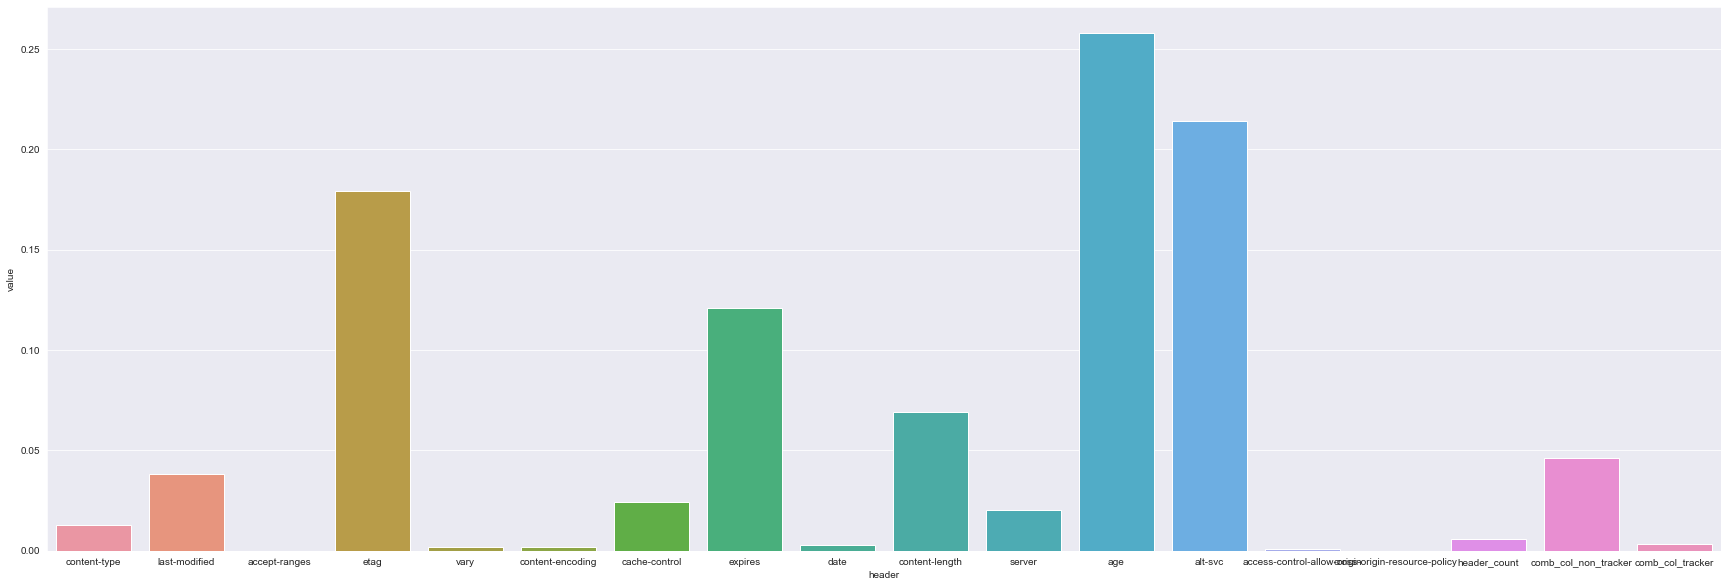

In [210]:
%matplotlib inline
plt.figure(figsize=(30, 10))
sns.barplot(data=pd.DataFrame(d), x='header', y='value')

In [211]:
rf.score(X_test, y_test['tracker'].to_numpy())

0.7815326245202276

In [212]:
clf_probs = rf.predict_proba(X_test)
score = metrics.log_loss(y_test, clf_probs)
print(score)

0.46241354102549004


In [226]:
knn = KNeighborsClassifier(n_jobs=-1)

In [227]:
%%time
knn.fit(X_train_2, y_train['tracker'].to_numpy())

CPU times: user 24.8 ms, sys: 15.5 ms, total: 40.3 ms
Wall time: 39.1 ms


KNeighborsClassifier(n_jobs=-1)

In [228]:
knn.score(X_test, y_test['tracker'].to_numpy())

0.6790341318510021

In [229]:
from sklearn.svm import SVC

In [ ]:
%%time
svm = SVC(kernel='linear')
svm.fit(X_train_2, y_train['tracker'].to_numpy())

In [ ]:
svm.score(X_test, y_test['tracker'].to_numpy())